In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import numpy as np
import preprocess_data
import textwrap
from IPython.display import clear_output
import numpy as np
from ipywidgets import Button, HTML, Output
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# INPUTS HERE:
INPUT_PATH = 

In [6]:
def rate_threshold_tf_idf(df, score_range=(5,15), n_samples=100, min_df=2, max_df=0.99):
    """
    Identify sentences with TF-IDF scores in a specified range and sample them for manual rating.
    """
    
    # Tokenize texts into sentences
    print("Tokenizing sentences...")
    text_column = "translatedText"
    
    # Get all sentences from all documents, tracking which doc they come from
    all_sentences_list = []
    for idx, txt in enumerate(df[text_column]):
        if pd.notna(txt) and isinstance(txt, str) and len(txt.strip()) > 0:
            sentences = nltk.sent_tokenize(txt)
            # Only keep first sentence
            if sentences and len(sentences[0].strip()) > 0:
                all_sentences_list.append(sentences[0])
    
    print(f"Found {len(all_sentences_list)} first sentences")
    
    if len(all_sentences_list) == 0:
        print("No valid sentences found!")
        return None
    
    # Create and fit TF-IDF vectorizer
    print("Fitting TF-IDF vectorizer...")
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=min_df,       
        max_df=max_df
    )
    tfidf = vectorizer.fit(all_sentences_list)
    
    # Calculate TF-IDF scores
    print("Calculating TF-IDF scores...")
    X = tfidf.transform(all_sentences_list)
    sentence_scores = np.asarray(X.mean(axis=1)).flatten()
    
    # Filter by score range
    min_score, max_score = np.percentile(sentence_scores, score_range[0]), np.percentile(sentence_scores, score_range[1])
    mask = (sentence_scores >= min_score) & (sentence_scores <= max_score)
    
    # Create DataFrame with sentences and scores in range
    candidates = pd.DataFrame({
        'sentence': [all_sentences_list[i] for i in range(len(all_sentences_list)) if mask[i]],
        'score': sentence_scores[mask]
    })
    
    if len(candidates) == 0:
        print("No sentences found in the specified score range!")
        return None
    
    sampled = candidates.sample(n=min(n_samples, len(candidates))).reset_index(drop=True)
    sampled['rating'] = None  # Initialize rating column
    # Calculate percentile for each sentence's score
    sampled['percentile'] = sampled['score'].apply(lambda x: (sentence_scores < x).sum() / len(sentence_scores) * 100)
    
    ratings = []
    current_index = [0]  # Use list to modify in nested function
    
    print(f"\n{'='*90}")
    print(f"Starting manual rating: {len(sampled)} sentences")
    print(f"{'='*90}\n")
    
    output = Output()
    display(output)
    
    def show_sentence(index):
        with output:
            output.clear_output(wait=True)
            if index >= len(sampled):
                print(f"Rating complete! Rated {len(ratings)}/{len(sampled)} sentences.")
                # Now add ratings to dataframe
                sampled.loc[:len(ratings)-1, 'rating'] = ratings
                print(f"\nFinal ratings: {ratings}")
                return
            
            row = sampled.iloc[index]
            print(f"Progress: {index+1}/{len(sampled)} sentences rated")
            print(f"\nSentence {index+1}/{len(sampled)}")
            print(f"TF-IDF score: {row['score']:.6f}")
            print("-" * 90)
            print(textwrap.fill(row['sentence'], width=90))
            print("-" * 90)
    
    def on_button_click(_button, rating_value):
        ratings.append(rating_value)
        sampled.loc[current_index[0], 'rating'] = rating_value
        current_index[0] += 1
        show_sentence(current_index[0])
    
    btn_correct = Button(description="1: Remove")
    btn_substantive = Button(description="0: Substantive")
    
    btn_correct.on_click(lambda b: on_button_click(b, 1))
    btn_substantive.on_click(lambda b: on_button_click(b, 0))
    
    show_sentence(0)
    display(btn_correct, btn_substantive)
    
    # Return the sampled dataframe 
    return sampled

In [4]:
# import preprocessed data
df = pd.read_csv(INPUT_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'data/parllaw/final.parquet'

In [ ]:
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,MEP,commission,written,multispeaker,link,translatedText,translationSource,year,block,party
0,1,Daniel Freund,"Frau Präsidentin, liebe Kolleginnen und Kolleg...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,2,,6403.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, dear colleagues! Politics mus...",machine_gm,2024,green,Greens/EFA
1,3,Sven Simon,"Madam President, colleagues, this last day of ...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,4,,6398.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, colleagues, this last day of ...",original_gm,2024,christian_conservative,PPE
2,4,Gabriele Bischoff,"Frau Präsidentin, werte Kommission, Kolleginne...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,5,,6399.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, honourable Commission, collea...",machine_gm,2024,social_democratic,PSE/S&D
3,5,Gilles Boyer,"Madame la Présidente, Monsieur le Commissaire,...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,6,,6401.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, Commissioner, it is always an...",machine_gm,2024,liberal,ELDR/ALDE/Renew
4,6,Heidi Hautala,"Madam President, we really have to thank Danie...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,7,,6403.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, we really have to thank Danie...",original_gm,2024,green,Greens/EFA


In [10]:
score_range=(5,10)

In [ ]:
# ratings = rate_threshold_tf_idf(df, score_range=score_range, n_samples=100)

Tokenizing sentences...
Found 462195 first sentences
Fitting TF-IDF vectorizer...
Found 462195 first sentences
Fitting TF-IDF vectorizer...
Calculating TF-IDF scores...
Calculating TF-IDF scores...

Starting manual rating: 100 sentences


Starting manual rating: 100 sentences



Output()

Button(description='1: Remove', style=ButtonStyle())

Button(description='0: Substantive', style=ButtonStyle())

In [ ]:
# save ratings: 
# ratings.to_csv(f"tf_idf_ratings_{rater}.csv")

In [7]:
ratings_jakob = pd.read_csv("tf_idf_ratings_Jakob.csv")
ratings_quirin = pd.read_csv("tf_idf_ratings_Quirin.csv")

In [8]:
ratings_both = [ratings_jakob, ratings_quirin]

Average rejection rate: 0.91


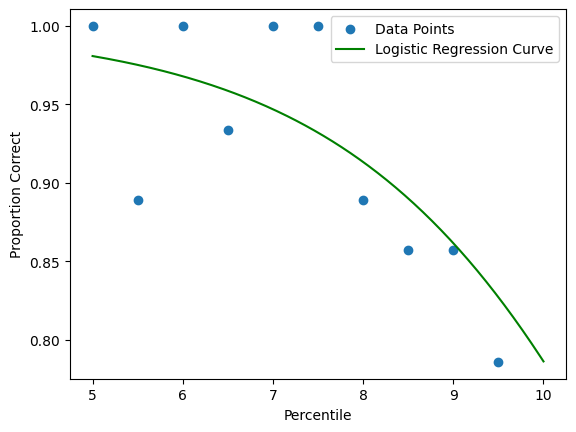

Percentile threshold for 95.0% accuracy: 6.877518324800006
Average rejection rate: 0.86


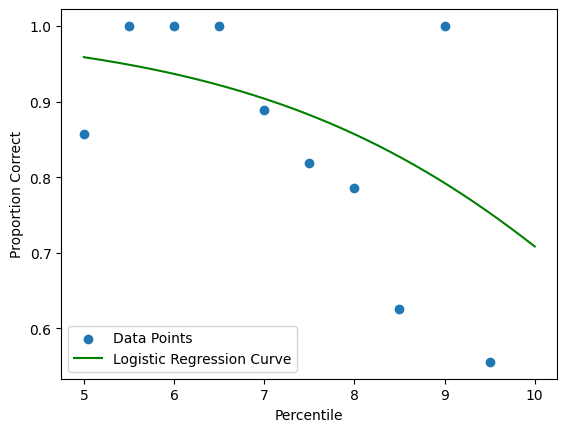

Percentile threshold for 95.0% accuracy: 5.441295693974213


In [ ]:
# compare ratings
for ratings in ratings_both:
    # print average rejection rate
    avg_rejection = ratings['rating'].mean()
    print(f"Average rejection rate: {avg_rejection:.2f}")
    # calculate mean ratings for every whole percentage step
    stepsize = 0.5
    percentile_segments = np.arange(score_range[0], score_range[1] + 1, stepsize)
    segment_n = len(percentile_segments)
    proportion_correct = []
    for i in range(len(percentile_segments)):
        if i == segment_n-1:
            upper_bound = percentile_segments[-1]
        else:
            lower_bound = percentile_segments[i]
            upper_bound = percentile_segments[i+1]
            segment_ratings = ratings[(ratings['percentile'] >= lower_bound) & (ratings['percentile'] < upper_bound)]
            if len(segment_ratings) > 0:
                prop_correct = segment_ratings['rating'].mean()
            else:
                prop_correct = np.nan
        proportion_correct.append(prop_correct)

    # fit logistic regression model
    from sklearn.linear_model import LogisticRegression
    # rating as categorical variable
    ratings['rating'] = ratings['rating'].astype(int)
    X = np.array(ratings["percentile"]).reshape(-1, 1)
    y = np.array(ratings["rating"]).reshape(-1, 1)
    log_model = LogisticRegression()
    log_model.fit(X, y.ravel())

    # plot logistic regression curve
    import numpy as np
    plt.figure()
    plt.scatter(percentile_segments, proportion_correct, label='Data Points')
    # Generate a range of percentiles for smooth curve
    x_range = np.linspace(score_range[0], score_range[1], 300).reshape(-1, 1)
    # Predict probabilities using the logistic model
    y_prob = log_model.predict_proba(x_range)[:, 1]
    plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')
    plt.xlabel('Percentile')
    plt.ylabel('Proportion Correct')
    plt.legend()
    plt.show()

    desired_accuracy = 0.95
    # Calculate the percentile threshold for the desired accuracy
    logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
    coef = log_model.coef_[0][0]
    intercept = log_model.intercept_[0]
    percentile_threshold = (logit_threshold - intercept) / coef
    print(f"Percentile threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")


Percentile threshold for 95.0% accuracy: 6.151912327799928
Average rejection rate: 0.89


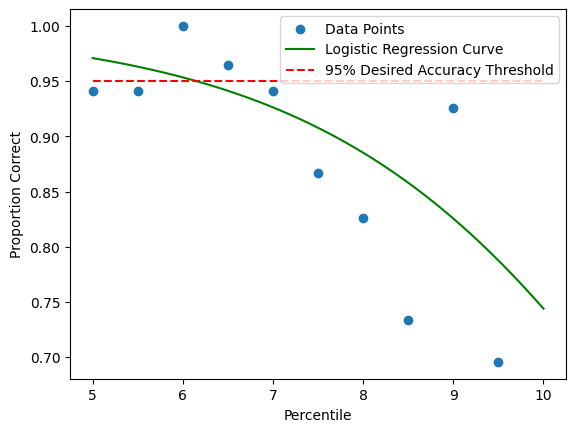

In [18]:
# combine ratings
ratings_combined = pd.concat(ratings_both, ignore_index=True)
desired_accuracy = 0.95

# Calculate the percentile threshold for the desired accuracy
logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
coef = log_model.coef_[0][0]
intercept = log_model.intercept_[0]
percentile_threshold = (logit_threshold - intercept) / coef
print(f"Percentile threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")

# print average rejection rate
avg_rejection = ratings_combined['rating'].mean()
print(f"Average rejection rate: {avg_rejection:.2f}")
# calculate mean ratings for every whole percentage step
stepsize = 0.5
percentile_segments = np.arange(score_range[0], score_range[1] + 1, stepsize)
segment_n = len(percentile_segments)
proportion_correct = []
for i in range(len(percentile_segments)):
    if i == segment_n-1:
        upper_bound = percentile_segments[-1]
    else:
        lower_bound = percentile_segments[i]
        upper_bound = percentile_segments[i+1]
        segment_ratings = ratings_combined[(ratings_combined['percentile'] >= lower_bound) & (ratings_combined['percentile'] < upper_bound)]
        if len(segment_ratings) > 0:
            prop_correct = segment_ratings['rating'].mean()
        else:
            prop_correct = np.nan
    proportion_correct.append(prop_correct)

# fit logistic regression model
from sklearn.linear_model import LogisticRegression
# rating as categorical variable
ratings_combined['rating'] = ratings_combined['rating'].astype(int)
X = np.array(ratings_combined["percentile"]).reshape(-1, 1)
y = np.array(ratings_combined["rating"]).reshape(-1, 1)
log_model = LogisticRegression()
log_model.fit(X, y.ravel())

# plot logistic regression curve
import numpy as np
plt.figure()
plt.scatter(percentile_segments, proportion_correct, label='Data Points')
# Generate a range of percentiles for smooth curve
x_range = np.linspace(score_range[0], score_range[1], 300).reshape(-1, 1)
# Predict probabilities using the logistic model
y_prob = log_model.predict_proba(x_range)[:, 1]
plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')
plt.hlines(y=desired_accuracy, xmin=score_range[0], xmax=score_range[1], colors='red', linestyles='dashed', label='95% Desired Accuracy Threshold')
plt.xlabel('Percentile')
plt.ylabel('Proportion Correct')
plt.legend()
plt.show()